# YouTube Analysis and Recommender System

In this notebook, we perform a detailed analysis of YouTube data to build a recommender system. YouTube, being one of the largest video-sharing platforms, holds a wealth of information that can be leveraged to understand user preferences, predict trends, and suggest relevant content.

## Overview

This project focuses on analyzing YouTube videos, their metadata, user interactions, and building a system that can recommend videos based on different factors such as view history, user preferences, and similar content.

## Objectives

- **Data Collection**: Retrieve YouTube video data, including video titles, descriptions, view counts, likes, and comments.
- **Data Preprocessing**: Clean and prepare the dataset for analysis.
- **Exploratory Data Analysis (EDA)**: Investigate patterns, trends, and insights from the dataset.
- **Recommender System**: Build a content-based or collaborative filtering recommender system to suggest videos to users.
- **Evaluation**: Evaluate the recommender system using appropriate metrics like accuracy, precision, and recall.

## Dataset

The dataset used in this analysis is collected from publicly available YouTube video statistics. It includes various features such as:

- Video Title
- Channel Name
- View Count
- Like Count
- Comment Count
- Video Description
- Tags
- Published Date

## Methodology

We will employ machine learning algorithms to build our recommender system. Depending on the approach, we might use:
- **Content-Based Filtering**: Recommending videos based on similarities between the content of videos.
- **Collaborative Filtering**: Recommending videos based on user interaction history and preferences.

The model will be evaluated based on the ability to suggest relevant and engaging videos to users.

## Conclusion

By the end of this notebook, we aim to have a fully functional recommender system capable of providing personalized video recommendations, enhancing user engagement, and improving their overall experience on YouTube.



## Initializing PySpark

Before using PySpark, we need to initialize the Spark session.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
    
spark = SparkSession.builder.appName("ScalingFix").config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    
sc = spark.sparkContext

your 131072x1 screen size is bogus. expect trouble
25/03/06 16:06:45 WARN Utils: Your hostname, SSMRS3-04979600 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/06 16:06:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/06 16:06:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load the Data from a CSV file

In [2]:
filePath = os.path.join(os.getcwd(), "dataset", "trending_yt_videos_113_countries.csv")
data = spark.read.format("csv").option("header", "true").option("sep", ",").option("multiLine", "true").option("quote", "\"").load(filePath)

data.show(20, False)

+--------------------------------------------------------------------------------------------------+-------------------------+----------+--------------+---------------+-------------+-------+----------+----------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Configure the Schema

Update the Schema with the proper data types and generate an object constructor using Rows

In [3]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- channel_name: string (nullable = true)
 |-- daily_rank: string (nullable = true)
 |-- daily_movement: string (nullable = true)
 |-- weekly_movement: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- country: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- description: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- video_tags: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- langauge: string (nullable = true)



In [3]:
schema = StructType([
    StructField('title', StringType(), True),
    StructField('channel_name', StringType(), True),
    StructField('daily_rank', IntegerType(), True),
    StructField('daily_movement', IntegerType(), True),
    StructField('weekly_movement', IntegerType(), True),
    StructField('snapshot_date', DateType(), True),
    StructField('country', StringType(), True),
    StructField('view_count', IntegerType(), True),
    StructField('like_count', IntegerType(), True),
    StructField('comment_count', IntegerType(), True),
    StructField('description', StringType(), True),
    StructField('thumbnail_url', StringType(), True),
    StructField('video_id', StringType(), True),
    StructField('channel_id', StringType(), True),
    StructField('video_tags', StringType(), True),
    StructField('kind', StringType(), True),
    StructField('country', StringType(), True),
    StructField('publish_date', DateType(), True),
    StructField('language', StringType(), True),
    ])

In [4]:
from pyspark.sql import Row

Video = Row('title', 'channel_name','daily_rank', 'daily_movement', 'weekly_movement', 'snapshot_date', 'country', 'view_count', 'like_count', 'comment_count', 
            'description', 'thumbnail_url', 'video_id', 'channel_id', 'video_tags', 'kind', 'country', 'publish_date', 'language')

# YouTube Dataset: Explicit vs. Implicit Data

Explicit data refers to information that is directly provided by the user, platform, or content creators,
whereas implicit data refers to information that is generated based on user interaction, platform algorithms, or system tracking.
In our dataset, we have a combination of both types of data, separated as follows:

## Explicit Data

- **title**: The title of the video, explicitly set by the uploader.
- **channel_name**: The name of the YouTube channel that uploaded the video.
- **description**: The text description provided by the video uploader.
- **thumbnail_url**: The URL of the thumbnail, explicitly assigned or auto-generated by YouTube.
- **video_id**: A unique identifier for the video, assigned by YouTube.
- **channel_id**: A unique identifier for the channel, assigned by YouTube.
- **video_tags**: Tags provided by the content creator for categorization and search optimization.
- **kind**: Indicates the type of content (e.g., YouTube video).
- **publish_date**: The date when the video was published, explicitly recorded by YouTube.
- **language** (or "langauge" as it appears in your dataset): The language setting for the video, either set by the uploader or inferred by YouTube.

## Implicit Data

- **daily_rank**: The ranking of the video for a given day, derived from engagement metrics.
- **daily_movement**: The change in ranking from the previous day, inferred from user engagement trends.
- **weekly_movement**: The ranking shift over a week, based on aggregated engagement data.
- **snapshot_date**: The date when the data was collected, recorded by the system.
- **country**: The country where the video is trending or where the snapshot was taken, inferred from viewer location data.
- **view_count**: The number of views the video has received, recorded and updated by YouTube.
- **like_count**: The number of likes, tracked as users interact with the content.
- **comment_count**: The number of comments, generated from user interactions.


## Filtering columns

As a starter to our project, we decided to cut some of the variables that are less likely to be userful in user recommendation. If needed, we will reload some of the columns needed.

In [5]:
columns_useful = ['title', 'channel_name', 'view_count', 'like_count', 'comment_count', 
                  'video_tags', 'kind', 'publish_date', 'langauge']  

#filter the columns that exists in the df
columns_validas = [c for c in columns_useful if c in data.columns]

# select only the valid columns
data = data.select([col(c) for c in columns_validas])

data.show(5)

+--------------------+------------+----------+----------+-------------+--------------------+-------------+--------------------+--------+
|               title|channel_name|view_count|like_count|comment_count|          video_tags|         kind|        publish_date|langauge|
+--------------------+------------+----------+----------+-------------+--------------------+-------------+--------------------+--------+
|Jah Prayzah - Man...| Jah Prayzah|    640294|     33578|         6942|                NULL|youtube#video|2025-02-17 00:00:...|    NULL|
|      Winky D - Siya| winkyonline|   1483949|     59662|        10408|                NULL|youtube#video|2025-02-01 00:00:...|    NULL|
|Winky D Fake Love...| winkyonline|   1031541|     48158|         6185|                NULL|youtube#video|2025-02-01 00:00:...|    NULL|
|Kendrick Lamar's ...|         NFL|  75930862|   2735285|       161203|NFL, Football, Am...|youtube#video|2025-02-10 00:00:...|      en|
|HIGHLIGHTS Real M...|    Man City|   416

## Generating new dimensions

We decided to create a new column called "Engagement Score" that uses a function of weights to generate a number that explains user interaction with the video.

We used a simple formula as shown below: 

$$
\text{Engagement Score} = \frac{\text{like\_count} \times 2 + \text{comment\_count} \times 3}{\text{view\_count} + 1}
$$


We decided to use these weights taking account the level of effort the user needs to put in order to perform these actions, meaning that they are more important the harder it is to do. The +1 on the view count is in order to avoid divisions by zero.

In [6]:
# Creating the engagement score column
data = data.withColumn("engagement_score", 
                       (col("like_count") * 2 + col("comment_count") * 3) / (col("view_count") + 1))

# Sorting by engagement score in descending order
data.orderBy(col("engagement_score").desc()).show(5)


+--------------------+------------+----------+----------+-------------+----------+-------------+--------------------+--------+----------------+
|               title|channel_name|view_count|like_count|comment_count|video_tags|         kind|        publish_date|langauge|engagement_score|
+--------------------+------------+----------+----------+-------------+----------+-------------+--------------------+--------+----------------+
|THE WEEKND - SÃO ...|  The Weeknd|         0|    456719|        11537|      NULL|youtube#video|2024-09-08 00:00:...|    NULL|        948049.0|
|THE WEEKND - SÃO ...|  The Weeknd|         0|    455188|        11468|      NULL|youtube#video|2024-09-08 00:00:...|    NULL|        944780.0|
|THE WEEKND - SÃO ...|  The Weeknd|         0|    453200|        11386|      NULL|youtube#video|2024-09-08 00:00:...|    NULL|        940558.0|
|THE WEEKND - SÃO ...|  The Weeknd|         0|    450683|        11282|      NULL|youtube#video|2024-09-08 00:00:...|    NULL|        93

## Normalising the Score

In [7]:

min_max_values = data.select(
    min("engagement_score").alias("min_score"),
    max("engagement_score").alias("max_score")
).first()

min_score = min_max_values["min_score"]
max_score = min_max_values["max_score"]

data = data.withColumn("scaled_engagement_score",
                       lit(1) + lit(9) * ((col("engagement_score") - lit(min_score)) / (lit(max_score) - lit(min_score))))

data.select("title", "engagement_score", "scaled_engagement_score") \
    .orderBy(col("scaled_engagement_score").desc()) \
    .show(5)

+--------------------+----------------+-----------------------+
|               title|engagement_score|scaled_engagement_score|
+--------------------+----------------+-----------------------+
|THE WEEKND - SÃO ...|        948049.0|                   10.0|
|THE WEEKND - SÃO ...|        944780.0|       9.96896690229517|
|THE WEEKND - SÃO ...|        940558.0|      9.928886835452165|
|THE WEEKND - SÃO ...|        935212.0|      9.878136471325515|
|THE WEEKND - SÃO ...|        928459.0|      9.814029249300214|
+--------------------+----------------+-----------------------+
only showing top 5 rows



## Data Association

We will now dive deeper in our dataset, generating different datasets that provide different information on our data

In [8]:
channel_engagement = data.groupBy("channel_name").agg(
    avg("engagement_score").alias("avg_engagement_score")
)

min_max_values_channel = channel_engagement.select(
    min("avg_engagement_score").alias("min_score"),
    max("avg_engagement_score").alias("max_score")
).first()

min_score_channel = min_max_values_channel["min_score"]
max_score_channel = min_max_values_channel["max_score"]

channel_analysis = channel_engagement.withColumn(
    "scaled_avg_engagement_score",
    lit(1) + lit(9) * ((col("avg_engagement_score") - lit(min_score)) / (lit(max_score) - lit(min_score)))
)

channel_analysis = channel_analysis.orderBy(col("avg_engagement_score").desc())

channel_analysis.show(10)


+--------------+--------------------+---------------------------+
|  channel_name|avg_engagement_score|scaled_avg_engagement_score|
+--------------+--------------------+---------------------------+
|    The Weeknd|  267825.54733086296|          3.542538737290481|
|     Coachella|  226829.63010400994|         3.1533584666266665|
| GoogleDoodles|  165461.95454545456|         2.5707860984630404|
|          Alok|  23462.932742165278|         1.2227685035986748|
|      Kenia Os|  18924.956264110922|          1.179688825585314|
|     FORMULA 1|   6430.476832086148|         1.0610768950300982|
|  Flow Podcast|    3586.58832136597|         1.0340794432054363|
|       KAROL G|  363.45340316978604|         1.0034817494666086|
|2SekundovyMato|   90.80283188998597|          1.000893437500318|
|        Raflow|  16.306878306878307|         1.0001862364583607|
+--------------+--------------------+---------------------------+
only showing top 10 rows



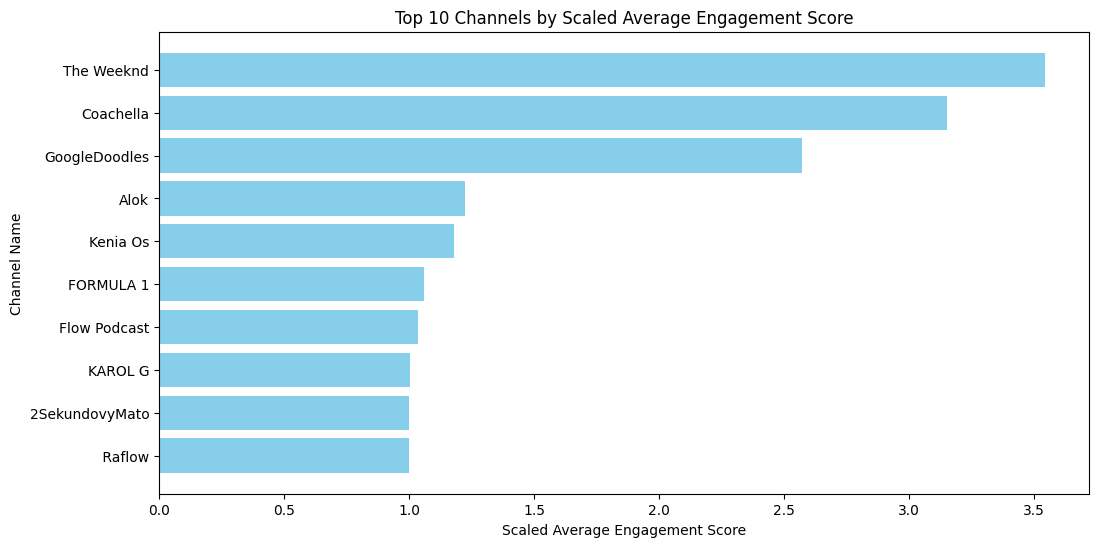

In [9]:
channel_analysis_pd = channel_analysis.toPandas()

channel_analysis_pd = channel_analysis_pd.sort_values(by="scaled_avg_engagement_score", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(channel_analysis_pd["channel_name"][:10], channel_analysis_pd["scaled_avg_engagement_score"][:10], color='skyblue')
plt.xlabel("Scaled Average Engagement Score")
plt.ylabel("Channel Name")
plt.title("Top 10 Channels by Scaled Average Engagement Score")
plt.gca().invert_yaxis() 
plt.show()

## Lets try to find similarities between videos

In [11]:
data.show(5)

+--------------------+------------+----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+
|               title|channel_name|view_count|like_count|comment_count|          video_tags|         kind|        publish_date|langauge|    engagement_score|scaled_engagement_score|
+--------------------+------------+----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+
|Jah Prayzah - Man...| Jah Prayzah|    640294|     33578|         6942|                NULL|youtube#video|2025-02-17 00:00:...|    NULL| 0.13740853825189953|     1.0000327373041344|
|      Winky D - Siya| winkyonline|   1483949|     59662|        10408|                NULL|youtube#video|2025-02-01 00:00:...|    NULL| 0.10145085750867616|     1.0000323959525836|
|Winky D Fake Love...| winkyonline|   1031541|     48158|         6185|                NUL

In [10]:
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import DenseVector
from pyspark.sql.functions import col
from sklearn.metrics.pairwise import euclidean_distances

data = (data.withColumn("view_count", col("view_count").cast("double"))
            .withColumn("like_count", col("like_count").cast("double"))
            .withColumn("comment_count", col("comment_count").cast("double"))
            .withColumn("scaled_engagement_score", col("scaled_engagement_score").cast("double")))


In [11]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- channel_name: string (nullable = true)
 |-- view_count: double (nullable = true)
 |-- like_count: double (nullable = true)
 |-- comment_count: double (nullable = true)
 |-- video_tags: string (nullable = true)
 |-- kind: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- langauge: string (nullable = true)
 |-- engagement_score: double (nullable = true)
 |-- scaled_engagement_score: double (nullable = true)



In [12]:
data = data.fillna(0, subset=["view_count", "like_count", "comment_count", "scaled_engagement_score"])

In [13]:
feature_cols = ["view_count", "like_count", "comment_count", "scaled_engagement_score"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_vector = vector_assembler.transform(data)


In [14]:
data_vector.select("features").show(5, truncate=False)

+---------------------------------------------------+
|features                                           |
+---------------------------------------------------+
|[640294.0,33578.0,6942.0,1.0000327373041344]       |
|[1483949.0,59662.0,10408.0,1.0000323959525836]     |
|[1031541.0,48158.0,6185.0,1.0000324900075686]      |
|[7.5930862E7,2735285.0,161203.0,1.0000321772773495]|
|[4166631.0,64473.0,3630.0,1.0000317514634163]      |
+---------------------------------------------------+
only showing top 5 rows



In [15]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_vector)
data_scaled = scaler_model.transform(data_vector)

In [16]:
scaled_pandas = data_scaled.select("title", "scaled_features").toPandas()

scaled_matrix = np.array([DenseVector(x).toArray() for x in scaled_pandas["scaled_features"]])

euclidean_matrix = euclidean_distances(scaled_matrix)

euclidean_df = pd.DataFrame(euclidean_matrix, index=scaled_pandas["title"], columns=scaled_pandas["title"])

print("Videos with Similar Engagement Patterns:")
print(euclidean_df.head(10))

MemoryError: Unable to allocate 376. TiB for an array with shape (7185258, 7185258) and data type float64

# Clustering


In [19]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Define features
feature_cols = ["view_count", "like_count", "comment_count", "scaled_engagement_score"]

# Assemble features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_vector = vector_assembler.transform(data)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_vector)
data_scaled = scaler_model.transform(data_vector)


In [20]:
# Apply KMeans clustering
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=4, seed=42)
kmeans_model = kmeans.fit(data_scaled)

# Generate predictions
data_clustered = kmeans_model.transform(data_scaled)

# Verify if prediction column exists
data_clustered.select("title", "channel_name", "view_count", "like_count", "comment_count", "cluster").show(10)


+--------------------+------------+-----------+----------+-------------+-------+
|               title|channel_name| view_count|like_count|comment_count|cluster|
+--------------------+------------+-----------+----------+-------------+-------+
|Jah Prayzah - Man...| Jah Prayzah|   640294.0|   33578.0|       6942.0|      0|
|      Winky D - Siya| winkyonline|  1483949.0|   59662.0|      10408.0|      0|
|Winky D Fake Love...| winkyonline|  1031541.0|   48158.0|       6185.0|      0|
|Kendrick Lamar's ...|         NFL|7.5930862E7| 2735285.0|     161203.0|      3|
|HIGHLIGHTS Real M...|    Man City|  4166631.0|   64473.0|       3630.0|      0|
|HIGHLIGHTS Man Ci...|    Man City|1.0558534E7|  203986.0|       8784.0|      0|
|            PA TONAZ| Comic Elder|   122104.0|    8758.0|        446.0|      0|
|Reach the Money, ...|     MrBeast|8.8610239E7| 3509581.0|       4820.0|      3|
|Bagga - Pengeleng...|  Baggamusic|   220647.0|       0.0|       1107.0|      0|
|Winky D ft Bling ...| winky

In [21]:
# Evaluate clustering performance
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_score = evaluator.evaluate(data_clustered)
print(f"Silhouette Score: {silhouette_score:.4f}")


Silhouette Score: 0.8712


In [22]:
data_clustered.select("title", "channel_name", "view_count", "like_count", "comment_count", "cluster").show(10)

+--------------------+------------+-----------+----------+-------------+-------+
|               title|channel_name| view_count|like_count|comment_count|cluster|
+--------------------+------------+-----------+----------+-------------+-------+
|Jah Prayzah - Man...| Jah Prayzah|   640294.0|   33578.0|       6942.0|      0|
|      Winky D - Siya| winkyonline|  1483949.0|   59662.0|      10408.0|      0|
|Winky D Fake Love...| winkyonline|  1031541.0|   48158.0|       6185.0|      0|
|Kendrick Lamar's ...|         NFL|7.5930862E7| 2735285.0|     161203.0|      3|
|HIGHLIGHTS Real M...|    Man City|  4166631.0|   64473.0|       3630.0|      0|
|HIGHLIGHTS Man Ci...|    Man City|1.0558534E7|  203986.0|       8784.0|      0|
|            PA TONAZ| Comic Elder|   122104.0|    8758.0|        446.0|      0|
|Reach the Money, ...|     MrBeast|8.8610239E7| 3509581.0|       4820.0|      3|
|Bagga - Pengeleng...|  Baggamusic|   220647.0|       0.0|       1107.0|      0|
|Winky D ft Bling ...| winky

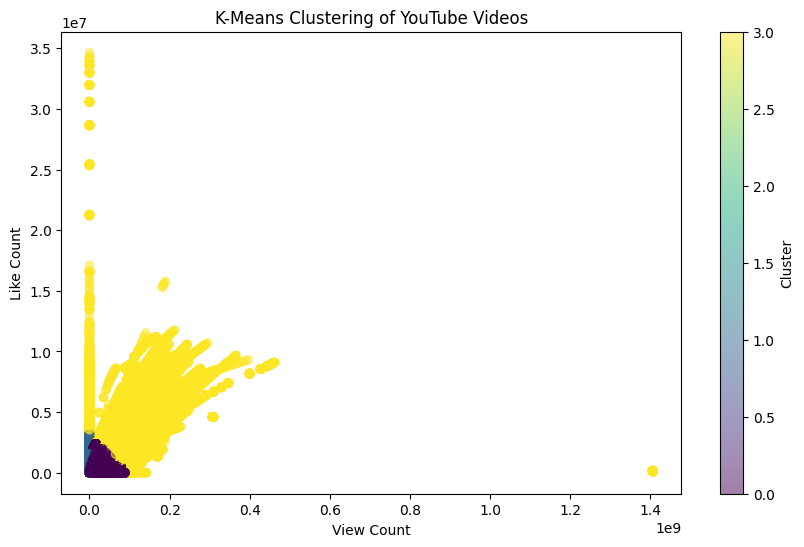

In [23]:
df_plot = data_clustered.select("view_count", "like_count", "comment_count", "cluster").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_plot["view_count"], df_plot["like_count"], c=df_plot["cluster"], cmap="viridis", alpha=0.5)
plt.xlabel("View Count")
plt.ylabel("Like Count")
plt.title("K-Means Clustering of YouTube Videos")
plt.colorbar(label="Cluster")
plt.show()
